# Notebook Application for Weekly Research on Daily Portfolio Companies using Tavily and LangGraph Agents

## Libraries

In [8]:
import os
import json
import asyncio
import operator
from typing import TypedDict, List, Annotated, Literal, Dict, Union, Optional 
from datetime import datetime

from tavily import AsyncTavilyClient, TavilyClient

from langchain_core.tools import tool
from langchain_core.messages import AnyMessage, AIMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel, Field, conlist
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, add_messages

## Set API KEYS

In [9]:
# load .env variables
from dotenv import load_dotenv
load_dotenv('.env')

True

## Code for Generating PDF Report

In [10]:
import re
from fpdf import FPDF

class PDF(FPDF):
    def header(self):
        self.set_font("Arial", "B", 12)
        self.cell(0, 10, "", 0, 1, "C")

    def footer(self):
        self.set_y(-15)
        self.set_font("Arial", "I", 8)
        self.cell(0, 10, f"Page {self.page_no()}", 0, 0, "C")

def sanitize_content(content):
    try:
        # Use 'utf-8' encoding to handle Unicode characters
        encoded_content = content.encode('utf-8', 'ignore').decode('utf-8')
        return encoded_content
    except UnicodeEncodeError as e:
        print(f"Encoding error: {e}")

        # Remove problematic characters using 'ascii' encoding
        sanitized_content = content.encode('ascii', 'ignore').decode('ascii')
        return sanitized_content

def replace_problematic_characters(content):
    # Replace or remove problematic characters
    replacements = {
        '\u2013': '-',  # en dash to hyphen
        '\u2014': '--',  # en dash to double hyphen
        '\u2018': "'",  # left single quotation mark to apostrophe
        '\u2019': "'",  # right single quotation mark to apostrophe
        '\u201c': '"',  # left double quotation mark to double quote
        '\u201d': '"',  # right double quotation mark to double quote
        '\u2026': '...',  # horizontal ellipsis
        '\u2010': '-',   # dash
        '\u2022': '*',   # bullet
        '\u2122': 'TM'  # TradeMark Symbol
    }

    for char, replacement in replacements.items():
        content = content.replace(char, replacement)

    return content

def generate_pdf_from_md(content, filename='output.pdf'):
    try:
        pdf = PDF()
        pdf.add_page()
        pdf.set_auto_page_break(auto=True, margin=15)
        pdf.set_font('Arial', '', 12)

        sanitized_content = sanitize_content(content)
        sanitized_content = replace_problematic_characters(sanitized_content)

        lines = sanitized_content.split('\n')

        for line in lines:
            if line.startswith('#'):
                header_level = min(line.count('#'), 4)
                header_text = re.sub(r'\*{2,}', '', line.strip('# ').strip())
                pdf.set_font('Arial', 'B', 12 + (4 - header_level) * 2)
                pdf.multi_cell(0, 10, header_text)
                pdf.set_font('Arial', '', 12)
            else:
                parts = re.split(r'(\*\*\*.*?\*\*\*|\*\*.*?\*\*|\*.*?\*|\[.*?\]\(.*?\)|\([^ ]+?\))', line)
                for part in parts:
                    if re.match(r'\*\*\*.*?\*\*\*', part):  # Bold Italic
                        text = part.strip('*')
                        pdf.set_font('Arial', 'BI', 12)
                        pdf.write(10, text)
                    elif re.match(r'\*\*.*?\*\*', part):  # Bold
                        text = part.strip('*')
                        pdf.set_font('Arial', 'B', 12)
                        pdf.write(10, text)
                    elif re.match(r'\*.*?\*', part):  # Italic
                        text = part.strip('*')
                        pdf.set_font('Arial', 'I', 12)
                        pdf.write(10, text)
                    elif re.match(r'\[.*?\]\(.*?\)', part):  # Markdown-style link
                        display_text = re.search(r'\[(.*?)\]', part).group(1)
                        url = re.search(r'\((.*?)\)', part).group(1)
                        pdf.set_text_color(0, 0, 255)  # Set text color to blue
                        pdf.set_font('', 'U')
                        pdf.write(10, display_text, url)
                        pdf.set_text_color(0, 0, 0)  # Reset text color
                        pdf.set_font('Arial', '', 12)
                    # elif re.match(r'\([^ ]+?\)', part):  # Plain URL
                    #     url = part[1:-1]
                    #     pdf.set_text_color(0, 0, 255)  # Set text color to blue
                    #     pdf.set_font('', 'U')
                    #     pdf.write(10, url, url)
                    else:
                        pdf.write(10, part)
                    pdf.set_text_color(0, 0, 0)             # Reset text color
                    pdf.set_font('Arial', '', 12)   # Reset font

                pdf.ln(10)

        pdf.output(filename)
        return f"PDF generated: {filename}"

    except Exception as e:
        return f"Error generating PDF: {e}"

## Create an Agentic Workflow

This code defines a workflow for conducting research on a company, gathering information from various sources (using **Tavily**), and generating a detailed report. It starts by setting up a `ResearchState` data structure, which holds the company's name, keywords, documents retrieved during research, and messages exchanged during the process.

The `Citation` and `QuotedAnswer` classes define how citations and answers should be structured when generating the report, ensuring clear and accurate referencing of sources.

The `TavilyQuery` and `TavilySearchInput` classes allow for multi-query searches using the **Tavily Search** tool, enabling more precise and efficient information gathering. The `tavily_search` function is an asynchronous tool that performs these searches in parallel, collecting and consolidating the results.

The `TavilyExtractInput` class defines the input structure for extracting raw content from URLs using **Tavily Extract**, allowing for more detailed information gathering when needed. This is especially useful in situations where summaries alone are insufficient, and deeper content extraction is required, such as in the case of detailed company research.

The workflow is managed by a `StateGraph`, which orchestrates the sequence of operations:

- The workflow starts at the `research` node to initiate the research process.
- Based on `should_continue`, it either continuing researching with *Tavily Search* or moves to curating the gathered documents using Tavily Extract (`curate` node).
- After curating, the workflow continues to `write`, where a detailed report with citations is written.
- Finally, `publish` converts the report into a PDF.

The workflow involves several key functions:

- `tool_node` handles the execution of search tools and stores the results for further processing. It ensures that only new documents are added to the `documents` dictionary, summarizing the findings in a message.
  
- `research_model` invokes the research model to gather relevant information about the company, based on recent developments in the past week. It uses the `tavily_search` tool to gather documents and provides specific instructions for focusing on the company's keywords. It also determines the next course of action in the workflow. Depending on the information gathered so far, the model decides whether to continue executing the **Tavily Search** tool to gather more data or to proceed to the next step. This decision-making capability is what makes the workflow agentic, allowing it to dynamically adapt to the specific research needs and ensure that the most relevant and comprehensive information is included in the final output.

- `should_continue` determines whether to continue using research tools or proceed to curating the gathered information based on the model's decision.

- `select_and_process` curates the gathered documents to retain those most relevant to the company. It generates a prompt for a model to filter the documents, excluding those with conflicting information or irrelevant keywords. The relevant documents are stored in `RAG_docs`, and additional raw content is extracted.

- `write_report` generates a detailed, in-depth report based on the curated documents (`RAG_docs`). The report is written in Markdown syntax, and includes a citation section with sources formatted as hyperlinks.

- `generete_pdf` converts the generated report into a PDF file and saves it to a designated directory for easy sharing and reference.

This setup enables an agentic approach to company research, resulting in a well-informed, well-cited report. By utilizing a multi-query strategy, document filtering, and additional extraction from selected documents, the workflow ensures efficient and accurate data processing.

In [11]:
# Define the research state
class ResearchState(TypedDict):
    company: str
    company_keywords: str
    exclude_keywords: str
    report: str
    # Declare a dictionary where:
    # - The outer dictionary has string keys.
    # - The inner dictionary can have keys of different types (e.g., str, int).
    # - The inner dictionary values can be of different types (e.g., str, float).
    documents: Dict[str, Dict[Union[str, int], Union[str, float]]]
    RAG_docs: Dict[str, Dict[Union[str, int], Union[str, float]]]
    messages: Annotated[list[AnyMessage], add_messages]

# Define the structure for the model's response, which includes citations.
class Citation(BaseModel):
    source_id: str = Field(
        ...,
        description="The url of a SPECIFIC source which justifies the answer.",
    )
    quote: str = Field(
        ...,
        description="The VERBATIM quote from the specified source that justifies the answer.",
    )


class QuotedAnswer(BaseModel):
    """Answer the user question based only on the given sources, and cite the sources used."""
    answer: str = Field(
        ...,
        description="The answer to the user question, which is based only on the given sources. Include any relevant sources in the answer as markdown hyperlinks. For example: 'This is a sample text ([url website](url))'"
    )
    citations: List[Citation] = Field(
        ..., description="Citations from the given sources that justify the answer."
    )
    
# Add Tavily's arguments to enhance the web search tool's capabilities
class TavilyQuery(BaseModel):
    query: str = Field(description="web search query")
    topic: str = Field(description="type of search, should be 'general' or 'news'. Choose 'news' ONLY when the company you searching is publicly traded and is likely to be featured on popular news")
    days: int = Field(description="number of days back to run 'news' search")
    # raw_content: bool = Field(description="include raw content from found sources, use it ONLY if you need more information besides the summary content provided")
    domains: Optional[List[str]] = Field(default=None, description="list of domains to include in the research. Useful when trying to gather information from trusted and relevant domains")
 

# Define the args_schema for the tavily_search tool using a multi-query approach, enabling more precise queries for Tavily.
class TavilySearchInput(BaseModel):
    sub_queries: List[TavilyQuery] = Field(description="set of sub-queries that can be answered in isolation")


class TavilyExtractInput(BaseModel):
    urls: List[str] = Field(description="list of a single or several URLs for extracting raw content to gather additional information")


@tool("tavily_search", args_schema=TavilySearchInput, return_direct=True)
async def tavily_search(sub_queries: List[TavilyQuery]):
    """Perform searches for each sub-query using the Tavily search tool concurrently."""  
    # Define a coroutine function to perform a single search with error handling
    async def perform_search(itm):
        try:
            # Add date to the query as we need the most recent results
            query_with_date = f"{itm.query} {datetime.now().strftime('%m-%Y')}"
            # Attempt to perform the search, hardcoding days to 7 (days will be used only when topic is news)
            response = await tavily_client.search(query=query_with_date, topic=itm.topic, days=itm.days, max_results=10)
            return response['results']
        except Exception as e:
            # Handle any exceptions, log them, and return an empty list
            print(f"Error occurred during search for query '{itm.query}': {str(e)}")
            return []
    
    # Run all the search tasks in parallel
    search_tasks = [perform_search(itm) for itm in sub_queries]
    search_responses = await asyncio.gather(*search_tasks)
    
    # Combine the results from all the responses
    search_results = []
    for response in search_responses:
        search_results.extend(response)
    
    return search_results

# Code for adding Tavily Extract as a tool (found it more useful to use Tavily Extract in a separate node)
# @tool("tavily_extract", args_schema=TavilyExtractInput, return_direct=True)
# async def tavily_extract(urls: TavilyExtractInput):
#     """Extract raw content from urls to gather additional information."""
#     try:
#         response = await tavily_client.extract(urls=urls)
#         return response['results']
#     except Exception as e:
#         # Handle any exceptions, log them, and return an empty list
#         print(f"Error occurred during extract: {str(e)}")
#         return []
    

tools = [tavily_search]
tools_by_name = {tool.name: tool for tool in tools}
tavily_client = AsyncTavilyClient()


# Define an async custom research tool node to store Tavily's search results for improved processing and later on filtering
async def tool_node(state: ResearchState):
    docs = state.get('documents',{})
    docs_str = ""
    msgs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        new_docs = await tool.ainvoke(tool_call["args"])
        for doc in new_docs:
            # Make sure that this document was not retrieved before
            if not docs or doc['url'] not in docs:
                docs[doc['url']] = doc
                docs_str += json.dumps(doc)
            # For Tavily Extract tool, checking if raw_content was retrieved a document
            # if doc.get('raw_content', None) and doc['url'] in docs:
            #     docs[doc['url']]['raw_content'] = doc['raw_content'] # add raw content retrieved by extract
            #     docs_str += json.dumps(doc)
        msgs.append(ToolMessage(content=f"Found the following new documents/information: {docs_str}", tool_call_id=tool_call["id"]))
    return {"messages": msgs, "documents": docs}
    
# Invoke a model with research tools to gather data about the company  
def research_model(state: ResearchState):
    prompt = f"""Today's date is {datetime.now().strftime('%d/%m/%Y')}.\n
You are an expert researcher tasked with gathering information for a weekly report on recent developments in portfolio companies.\n
Your current objective is to gather documents about any significant events that occurred in the past week for the following company: {state['company']}.\n
The user has provided the following company keywords: {state['company_keywords']} to help you find documents relevant to the correct company.\n     
**Instructions:**\n
- Use the 'tavily_search' tool to search for relevant documents
- Focus on gathering documents by making appropriate tool calls
- If you believe you have gathered enough information, state 'I have gathered enough information and am ready to proceed.'
"""
    messages = state['messages'] + [SystemMessage(content=prompt)]
    model = ChatOpenAI(model="gpt-4o-mini",temperature=0)
    response = model.bind_tools(tools).invoke(messages)
    return {"messages": [response]}
    

# Define the function that decides whether to continue research using tools or proceed to writing the report
def should_continue(state: ResearchState) -> Literal["tools", "curate"]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user with citations)
    return "curate"

async def select_and_process(state: ResearchState):
    msg = "Curating Documents ...\n"
    prompt = f"""You are an expert researcher specializing in analyzing portfolio companies.\n
Your current task is to review a list of documents and select the most relevant URLs related to recent developments for the following company: {state['company']}.\n
Be aware that some documents may refer to other companies with similar or identical names, potentially leading to conflicting information.\n
Your objective is to choose the documents that pertain to the correct company and provide the most consistent and synchronized information, using the following keywords provided by the user to help identify the correct company as a guide:{state['company_keywords']}.\n"""
    # Optionally include exclusion keywords if provided by the user 
    if state['exclude_keywords'] != "":
        prompt += f"""Additionally, if any form of the following exclusion words are present in the documents, do not include them and filter out those documents: {state['exclude_keywords']}.\n"""
    # Append the list of gathered documents to the prompt
    prompt += f"""\nHere is the list of documents gathered for your review:\n{state['documents']}\n\n"""

    # Use the model to filter documents and obtain relevant URLs structured as TavilyExtractInput
    messages = [SystemMessage(content=prompt)]  
    model = ChatOpenAI(model="gpt-4o-mini",temperature=0)
    relevant_urls = model.with_structured_output(TavilyExtractInput).invoke(messages)
    
    # Create a dictionary of relevant documents based on the URLs returned by the model
    RAG_docs = {url: state['documents'][url] for url in relevant_urls.urls if url in state['documents']}

    try:
        # Extract raw content from the selected URLs using the Tavily client
        response = await tavily_client.extract(urls=relevant_urls.urls)
        
        # Save the raw content into the RAG_docs dictionary for each URL
        msg += "Extracted raw content for:\n"
        for itm in response['results']:
            url = itm['url']
            msg += f"{url}\n" 
            raw_content = itm['raw_content']
            RAG_docs[url]['raw_content'] = raw_content
    except Exception as e:
        print(f"Error occurred during Tavily Extract request")
        
    msg += f"ֿֿ\n\nState of RAG documents that will be used for the report:\n\n{RAG_docs}"
        
    return {"messages": [AIMessage(content=msg)],"RAG_docs": RAG_docs}
            
# Define the function to write the report based on the retrieved documents.
def write_report(state: ResearchState):
    # Create the prompt
    prompt = f"""Today's date is {datetime.now().strftime('%d/%m/%Y')}\n.
You are an expert researcher, writing a weekly report about recent events in portfolio companies.\n
Your task is to write an in-depth, well-written, and detailed report on the following company: {state['company']}. in markdown syntax\n
Here are all the documents you should base your answer on:\n{state['RAG_docs']}\n""" 
    # messages = [state['messages'][-1]] + [SystemMessage(content=prompt)] 
    # Create a system message with the constructed prompt (no need to include entire chat history)
    messages = [SystemMessage(content=prompt)] 
    model = ChatOpenAI(model="gpt-4o-mini",temperature=0)
    response = model.with_structured_output(QuotedAnswer).invoke(messages)
    full_report = response.answer
    # Add Citations Section to the report
    full_report += "\n\n### Citations\n"
    for citation in response.citations:
        doc = state['RAG_docs'].get(citation.source_id)
        full_report += f"- [{doc.get('title',citation.source_id)}]({citation.source_id}): \"{citation.quote}\"\n"
    # We return a list, because this will get added to the existing list
    return {"messages": [AIMessage(content=f"Generated Report:\n{full_report}")], "report": full_report}

def generete_pdf(state: ResearchState):
    directory = "reports"
    file_name = f"{state['company']} Weekly Report {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    # Check if the directory exists
    if not os.path.exists(directory):
        # Create the directory
        os.makedirs(directory)
    msg = generate_pdf_from_md(state['report'], filename=f'{directory}/{file_name}.pdf')
    return {"messages": [AIMessage(content=msg)]}

# Define a graph
workflow = StateGraph(ResearchState)

# Add nodes
workflow.add_node("research", research_model)
workflow.add_node("tools", tool_node)
workflow.add_node("curate", select_and_process)
workflow.add_node("write", write_report)
workflow.add_node("publish", generete_pdf)
# Set the entrypoint as route_query
workflow.set_entry_point("research")

# Determine which node is called next
workflow.add_conditional_edges(
    "research",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# Add a normal edge from `tools` to `research`.
# This means that after `tools` is called, `research` node is called next in  order to determine if we should keep  or move to the 'curate' step
workflow.add_edge("tools", "research")
workflow.add_edge("curate","write")
workflow.add_edge("write", "publish")  # Option in the future, to add another step and filter the documents retrieved using rerhank before writing the report
workflow.add_edge("publish", END)  # Option in the future, to add another step and filter the documents retrieved using rerhank before writing the report

app = workflow.compile()

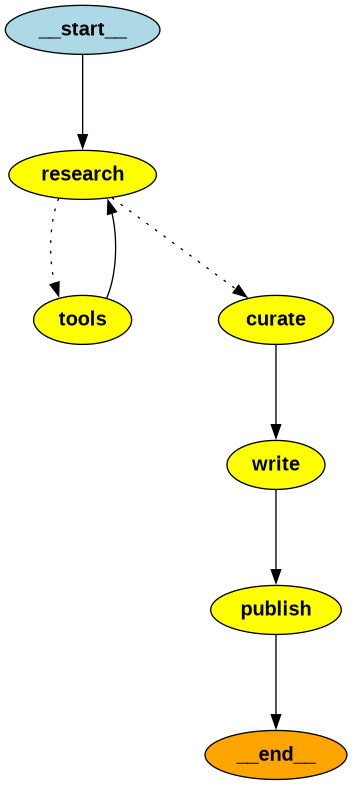

In [12]:
# If you want to visualize graph, need to pip install pygraphviz
from IPython.display import Image

Image(app.get_graph().draw_png())

# Run Research

In [13]:
company = "Athena Intelligence"
company_keywords = "data analyst, AI-native analyst platform"
# (Optional) exclude_keywords: Use this field when you need to differentiate the company from others with the same name in a different industry
# or when you want to exclude specific types of documents or information. Leave it as an empty string ("") if not needed.
exclude_keywords = "wildfire"
# You may uncomment your_additional_guidelines and HumanMessage and update the content with some guidelines of your own
# your_additional_guidelines=f"Note that the {company} is ... / focus on ...."
messages = [
    SystemMessage(content="You are an expert researcher ready to begin the information gathering process.")
    # ,HumanMessage(content=your_additional_guidelines)
]
async for s in app.astream({"company": company, "company_keywords": company_keywords, "exclude_keywords": exclude_keywords, "messages":messages}, stream_mode="values"):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================ System Message ================================

You are an expert researcher ready to begin the information gathering process.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_FMmWlDy19NOTg9KHvckOGeYe)
 Call ID: call_FMmWlDy19NOTg9KHvckOGeYe
  Args:
    sub_queries: [{'query': 'Athena Intelligence data analyst', 'topic': 'general', 'days': 7}, {'query': 'Athena Intelligence AI-native analyst platform', 'topic': 'general', 'days': 7}]
================================= Tool Message =================================

Found the following new documents/information: {"title": "Athena Data Analyst Work, Jobs - 30 November, 2024 - Indeed", "url": "https://ph.indeed.com/q-athena-data-analyst-jobs.html", "content": "athena data analyst jobs. Sort by: relevance - date. 12 jobs. Senior Data Analyst. InDebted. Remote. Experience training and developing data analysts. ... Gather business intelligence 